In [225]:
import os
import sys
from pathlib import Path
import ast
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, hstack
# Setting the working directory to the root of the project
project_dir = Path("C:/Users/adbou/source/repos/KFHXRelatedAi/")
os.chdir(project_dir)

from Configs.GeneralPaths import SOURCEDATA
import pandas as pd
import numpy as np
from collections import defaultdict
pd.set_option('display.max_columns', None)

In [226]:
#load user profiles data
user_profiles = pd.read_excel(Path(SOURCEDATA / "User_Profiles_Reports.xlsx"))
user_profiles.head()
user_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17825 entries, 0 to 17824
Columns: 177 entries, FK_BusinessUserId to spender_category
dtypes: float64(159), int64(15), object(3)
memory usage: 24.1+ MB


In [227]:
user_profiles.head()

,FK_BusinessUserId,total_transactions,total_amount_spent,avg_points_rewarded,avg_amount_spent,total_amount_mcc_763,total_amount_mcc_3038,total_amount_mcc_3583,total_amount_mcc_4111,total_amount_mcc_4225,total_amount_mcc_4468,total_amount_mcc_4814,total_amount_mcc_4900,total_amount_mcc_5047,total_amount_mcc_5085,total_amount_mcc_5099,total_amount_mcc_5111,total_amount_mcc_5131,total_amount_mcc_5199,total_amount_mcc_5261,total_amount_mcc_5262,total_amount_mcc_5300,total_amount_mcc_5309,total_amount_mcc_5310,total_amount_mcc_5399,total_amount_mcc_5499,total_amount_mcc_5533,total_amount_mcc_5651,total_amount_mcc_5712,total_amount_mcc_5732,total_amount_mcc_5733,total_amount_mcc_5812,total_amount_mcc_5815,total_amount_mcc_5816,total_amount_mcc_5817,total_amount_mcc_5818,total_amount_mcc_5940,total_amount_mcc_5942,total_amount_mcc_5944,total_amount_mcc_5947,total_amount_mcc_5949,total_amount_mcc_5960,total_amount_mcc_5962,total_amount_mcc_5965,total_amount_mcc_5967,total_amount_mcc_5968,total_amount_mcc_5969,total_amount_mcc_5970,total_amount_mcc_5972,total_amount_mcc_5977,total_amount_mcc_5992,total_amount_mcc_5993,total_amount_mcc_5995,total_amount_mcc_5999,total_amount_mcc_6300,total_amount_mcc_6540,total_amount_mcc_7211,total_amount_mcc_7216,total_amount_mcc_7221,total_amount_mcc_7230,total_amount_mcc_7251,total_amount_mcc_7273,total_amount_mcc_7277,total_amount_mcc_7297,total_amount_mcc_7299,total_amount_mcc_7321,total_amount_mcc_7338,total_amount_mcc_7361,total_amount_mcc_7375,total_amount_mcc_7392,total_amount_mcc_7393,total_amount_mcc_7399,total_amount_mcc_7512,total_amount_mcc_7523,total_amount_mcc_7993,total_amount_mcc_7996,total_amount_mcc_8111,total_amount_mcc_8299,total_amount_mcc_8351,total_amount_mcc_8398,total_amount_mcc_8911,total_amount_mcc_8999,total_amount_mcc_9399,recency,most_common_day_of_week,most_common_month,most_common_season,most_frequent_mcc,most_frequent_location,763,3038,3583,4111,4225,4468,4814,4900,5047,5085,5099,5111,5131,5199,5261,5262,5300,5309,5310,5399,5499,5533,5651,5712,5732,5733,5812,5815,5816,5817,5818,5940,5942,5944,5947,5949,5960,5962,5965,5967,5968,5969,5970,5972,5977,5992,5993,5995,5999,6300,6540,7211,7216,7221,7230,7251,7273,7277,7297,7299,7321,7338,7361,7375,7392,7393,7399,7512,7523,7993,7996,8111,8299,8351,8398,8911,8999,9399,unique_mccs,weekend_transactions,weekday_transactions,avg_transactions_per_month,R,F,M,RFM_Score,RFM_Segment,spender_category
0,976481,54,1136.25,210.148148,21.041667,0.0,204.53,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.25,460.49,32.0,147.92,0.00,5.00,0.0,0.00,0.0,0.00,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,68.06,24,0,4,2,5499,KW,0.0,0.055556,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.037037,0.611111,0.018519,0.111111,0.000000,0.018519,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.092593,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.018519,0.0,0.0,0.0,0.000000,0.0,0.0,0.037037,9,15,39,7.714286,5,5,5,5,Champions,medium
1,976482,40,422.74,105.150000,10.568500,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,138.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,73.59,0.0,24.40,14.55,25.50,0.0,105.75,0.0,0.00,0.0,0.0,0.0,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.1,0,0.00,0.0,0.0,0.0,5.95,0.0,0.0,0.0,0.0,0.0,0.0,0.00,76,0,4,1,5812,KW,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.125000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.200000,0.000000,0.025000,0.050000,0.025000,0.0,0.475000,0.0,0.000000,0.000000,0.000000,0.000000,0.05,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0

In [228]:
user_transactions = pd.read_excel(Path(SOURCEDATA / "Transaction_User.xlsx"))
new_user_transaction = user_transactions.drop(columns=['TrxId'])

deals_data = pd.read_excel(Path(SOURCEDATA / "Rdepemtion_Cleaned_Deals.xlsx"))
deals_data = deals_data.drop(columns=['Unnamed: 0.1'])

deals_profiles = pd.read_excel(Path(SOURCEDATA / "Updated_Content_Profiles.xlsx"))

deals_embeddings = pd.read_csv(Path(SOURCEDATA / "Deals_Embeddings_test.csv"))
deals_embeddings['ada_embedding'] = deals_embeddings['ada_embedding'].apply(ast.literal_eval)

new_user_transaction = new_user_transaction.merge(deals_data[['ContentId', 'Categories','Deal Type']], left_on='FK_ContentId', right_on='ContentId', how='left')
new_user_transaction = new_user_transaction.drop(columns=['ContentId'])

# Load MCC mapping data
mcc_mapping = pd.read_excel(Path(SOURCEDATA / "MCC_Details.xlsx"))
mcc_embeddings = pd.read_csv(Path(SOURCEDATA / "Unique_MCCs_Embeddings.csv"))

# Convert MCC in mcc_mapping to string
mcc_mapping['MCC'] = mcc_mapping['MCC'].astype(str)

In [229]:
deals_profiles.head()

,FK_ContentId,Deal Value Segment,RedemptionCount,TotalPointsRedeemed,MostCommonMonth,MostCommonDayOfWeek,WeekendRedemptionRatio,MostCommonSeason
0,113815,High-End Deal,1,15000,0,0,0.000000,0
1,113816,High-End Deal,1,10000,10,2,0.000000,Autumn
2,113817,High-End Deal,372,1860000,2,2,0.266129,Accross Seasons
3,113818,Medium Budget Deal,1,3000,0,0,0.000000,0
4,113819,Medium Budget Deal,2743,8229000,4,6,0.341232,Spring


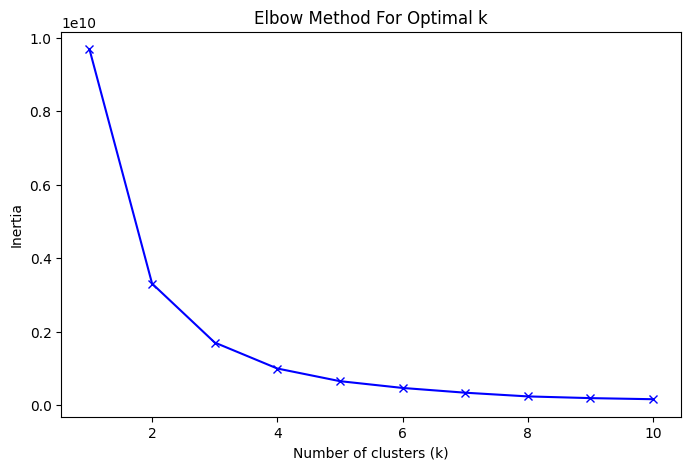

In [230]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Reshape data for clustering
spending_data = user_profiles[['total_amount_spent']].values.reshape(-1, 1)

# Elbow method to determine the optimal number of clusters
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(spending_data)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [231]:
from sklearn.cluster import KMeans

# Reshaping data for clustering
spending_data = user_profiles[['total_amount_spent']].values.reshape(-1, 1)

# Applying KMeans clustering k=3 using elbow method calculated above
kmeans = KMeans(n_clusters=3 , random_state=0).fit(spending_data)
user_profiles['spender_category'] = kmeans.labels_

# Mapping cluster labels to meaningful categories
cluster_map = {0: 'low', 1: 'medium', 2: 'high'}
user_profiles['spender_category'] = user_profiles['spender_category'].map(cluster_map)

print(user_profiles[['FK_BusinessUserId', 'total_amount_spent', 'spender_category']])

       FK_BusinessUserId  total_amount_spent spender_category
0                 976481             1136.25           medium
1                 976482              422.74              low
2                 976483             1905.77           medium
3                 976484              214.26              low
4                 976485             6016.55             high
...                  ...                 ...              ...
17820            1124902                7.95              low
17821            1124919               39.63              low
17822            1124944               22.00              low
17823            1125078                3.75              low
17824            1125100                4.40              low

[17825 rows x 3 columns]


In [232]:
user_profiles.head()

,FK_BusinessUserId,total_transactions,total_amount_spent,avg_points_rewarded,avg_amount_spent,total_amount_mcc_763,total_amount_mcc_3038,total_amount_mcc_3583,total_amount_mcc_4111,total_amount_mcc_4225,total_amount_mcc_4468,total_amount_mcc_4814,total_amount_mcc_4900,total_amount_mcc_5047,total_amount_mcc_5085,total_amount_mcc_5099,total_amount_mcc_5111,total_amount_mcc_5131,total_amount_mcc_5199,total_amount_mcc_5261,total_amount_mcc_5262,total_amount_mcc_5300,total_amount_mcc_5309,total_amount_mcc_5310,total_amount_mcc_5399,total_amount_mcc_5499,total_amount_mcc_5533,total_amount_mcc_5651,total_amount_mcc_5712,total_amount_mcc_5732,total_amount_mcc_5733,total_amount_mcc_5812,total_amount_mcc_5815,total_amount_mcc_5816,total_amount_mcc_5817,total_amount_mcc_5818,total_amount_mcc_5940,total_amount_mcc_5942,total_amount_mcc_5944,total_amount_mcc_5947,total_amount_mcc_5949,total_amount_mcc_5960,total_amount_mcc_5962,total_amount_mcc_5965,total_amount_mcc_5967,total_amount_mcc_5968,total_amount_mcc_5969,total_amount_mcc_5970,total_amount_mcc_5972,total_amount_mcc_5977,total_amount_mcc_5992,total_amount_mcc_5993,total_amount_mcc_5995,total_amount_mcc_5999,total_amount_mcc_6300,total_amount_mcc_6540,total_amount_mcc_7211,total_amount_mcc_7216,total_amount_mcc_7221,total_amount_mcc_7230,total_amount_mcc_7251,total_amount_mcc_7273,total_amount_mcc_7277,total_amount_mcc_7297,total_amount_mcc_7299,total_amount_mcc_7321,total_amount_mcc_7338,total_amount_mcc_7361,total_amount_mcc_7375,total_amount_mcc_7392,total_amount_mcc_7393,total_amount_mcc_7399,total_amount_mcc_7512,total_amount_mcc_7523,total_amount_mcc_7993,total_amount_mcc_7996,total_amount_mcc_8111,total_amount_mcc_8299,total_amount_mcc_8351,total_amount_mcc_8398,total_amount_mcc_8911,total_amount_mcc_8999,total_amount_mcc_9399,recency,most_common_day_of_week,most_common_month,most_common_season,most_frequent_mcc,most_frequent_location,763,3038,3583,4111,4225,4468,4814,4900,5047,5085,5099,5111,5131,5199,5261,5262,5300,5309,5310,5399,5499,5533,5651,5712,5732,5733,5812,5815,5816,5817,5818,5940,5942,5944,5947,5949,5960,5962,5965,5967,5968,5969,5970,5972,5977,5992,5993,5995,5999,6300,6540,7211,7216,7221,7230,7251,7273,7277,7297,7299,7321,7338,7361,7375,7392,7393,7399,7512,7523,7993,7996,8111,8299,8351,8398,8911,8999,9399,unique_mccs,weekend_transactions,weekday_transactions,avg_transactions_per_month,R,F,M,RFM_Score,RFM_Segment,spender_category
0,976481,54,1136.25,210.148148,21.041667,0.0,204.53,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.25,460.49,32.0,147.92,0.00,5.00,0.0,0.00,0.0,0.00,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,68.06,24,0,4,2,5499,KW,0.0,0.055556,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.037037,0.611111,0.018519,0.111111,0.000000,0.018519,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.092593,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.018519,0.0,0.0,0.0,0.000000,0.0,0.0,0.037037,9,15,39,7.714286,5,5,5,5,Champions,medium
1,976482,40,422.74,105.150000,10.568500,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,138.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,73.59,0.0,24.40,14.55,25.50,0.0,105.75,0.0,0.00,0.0,0.0,0.0,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.1,0,0.00,0.0,0.0,0.0,5.95,0.0,0.0,0.0,0.0,0.0,0.0,0.00,76,0,4,1,5812,KW,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.125000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.200000,0.000000,0.025000,0.050000,0.025000,0.0,0.475000,0.0,0.000000,0.000000,0.000000,0.000000,0.05,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0

In [233]:
def is_numeric_column(col_name):
    try:
        int(col_name)
        return True
    except ValueError:
        return False


mcc_columns = [col for col in user_profiles.columns if is_numeric_column(col)]

mcc_amounts_cols = [col for col in user_profiles.columns.astype(str) if col.startswith('total_amount_mcc_')]

def calculate_user_interest_score(user_id):
    user_data = user_profiles[user_profiles['FK_BusinessUserId'] == user_id]
    
    total_frequencies = user_data[mcc_columns].sum(axis=1).values[0]
    total_paid_amount = user_data[mcc_amounts_cols].sum(axis=1).values[0]
    
    mcc_scores = {}
    if total_frequencies > 0 and total_paid_amount > 0:
        for mcc in mcc_columns:
            frequency = user_data[mcc].values[0]
            amount_col = f'total_amount_mcc_{mcc}'
            if amount_col in user_data.columns:
                amount = user_data[amount_col].values[0]
                if frequency > 0 and amount > 0:
                    score = (frequency / total_frequencies) * (amount / total_paid_amount)
                    mcc_scores[mcc] = score
    
    return mcc_scores

In [234]:
def convert_to_array(x):
    if isinstance(x, str):  # If x is a string, try to evaluate it
        try:
            return np.array(ast.literal_eval(x))
        except (ValueError, SyntaxError):
            raise ValueError(f"Cannot convert to array: {x}")
    elif isinstance(x, (list, np.ndarray)):  # If x is already a list or array, convert to np.array
        return np.array(x)
    else:
        raise ValueError(f"Unexpected format: {x}")

In [235]:
def get_top_n_mccs(user_profiles , n=2):
    #Identifying MCC columns for amount and frequency in user_profiles
    mcc_amount_columns = [col for col in user_profiles.columns if str(col).startswith('total_amount_mcc_')]
    mcc_frequency_columns = [col for col in user_profiles.columns if str(col).isdigit()]

    # Normalizing the frequency and amount of MCCs
    mcc_amount_sums = user_profiles[mcc_amount_columns].sum()
    mcc_frequency_sums = user_profiles[mcc_frequency_columns].sum()

    normalized_amount = mcc_amount_sums / mcc_amount_sums.sum()
    normalized_frequency = mcc_frequency_sums / mcc_frequency_sums.sum()

    # Combining the metrics (we multiply with equal weight for simplicity)
    combined_score = 0.5 * normalized_amount.values + 0.5 * normalized_frequency.values 

    #Rank and selecting the top 10 MCCs
    combined_score_series = pd.Series(combined_score, index=mcc_frequency_columns)
    top_10_mccs = combined_score_series.sort_values(ascending=False).head(n)

    top_mccs_df = top_10_mccs.reset_index()
    top_mccs_df.columns = ['MCC', 'Score']
    top_mccs_df['MCC'] = top_mccs_df['MCC'].astype(str)
    top_mccs_with_details = pd.merge(top_mccs_df, mcc_mapping, on='MCC', how='left')
    top_mccs_with_details
    return top_mccs_with_details

top_mccs = get_top_n_mccs(user_profiles , 2)

In [243]:
def recommend_based_on_profiles(user_id, deal_embeddings, deal_data, user_profiles,n_similar_items = 10 , isDf = False):
    # Implementing a recommendation strategy based on user profiles alone
    user_profile = user_profiles[user_profiles['FK_BusinessUserId'] == user_id]
    spender_category = user_profiles.loc[user_profiles['FK_BusinessUserId'] == user_id, 'spender_category'].values[0]
    print(f"Spender Category {spender_category}")

    #calculating mcc_scores
    mcc_scores = calculate_user_interest_score(user_id)

    # Merging the MCC scores with MCC mapping
    mcc_scores_df = pd.DataFrame.from_dict(mcc_scores, orient='index', columns=['Score'])
    mcc_scores_df.reset_index(inplace=True)
    mcc_scores_df.columns = ['MCC', 'Score']
    mcc_scores_df['MCC'] = mcc_scores_df['MCC'].astype(str)  # Convert MCC to string
    mcc_scores_df = mcc_scores_df.merge(mcc_mapping, on='MCC', how='left')
    mcc_scores_df = mcc_scores_df.sort_values(by='Score', ascending=False)

    # Creating labels combining MCC and description
    mcc_scores_df['Label'] = mcc_scores_df['MCC'] + ' - ' + mcc_scores_df['Detailed MCC']

    spender_ranges = {
        'low': ['Low-Budget Deal'],
        'medium': ['Medium Budget Deal','Low-Budget Deal'],
        'high': ['High-End Deal']
    }

    recommendations = []

    #user mccs embeddings
    mcc_embeddings['ada_embedding'] = mcc_embeddings['ada_embedding'].apply(convert_to_array)

    # Creating the embeddings dictionary
    mcc_embedding_dict = mcc_embeddings.set_index('MCC')['ada_embedding'].to_dict()

    # Filtering and collecting the embeddings that matches the user's MCC scores
    matched_embeddings = [mcc_embedding_dict[mcc] for mcc in mcc_scores.keys() if mcc in mcc_embedding_dict]


    user_embedding = np.mean(matched_embeddings, axis=0)


    # Getting top MCC scores
    mcc_scores_df = mcc_scores_df.sort_values(by='Score', ascending=False)

    user_mcc_scores = mcc_scores_df.set_index('Detailed MCC')['Score'].to_dict()

    
    for index, row in deal_data.iterrows():
        content_id = row['ContentId']
        item_mcc = row['Categories']
        deal_segment = deals_profiles.loc[deals_profiles['FK_ContentId'] == content_id, 'Deal Value Segment'].values[0]
        deal_embedding = np.array(deal_embeddings.loc[deal_embeddings['ContentId'] == content_id, 'ada_embedding'].values[0])
        score = cosine_similarity([user_embedding], [deal_embedding])[0][0]
        
        if item_mcc in top_mccs["Detailed MCC"].tolist():
            score *= 0.5

        # Adjusting the score based on MCC interest scores of the user
        if item_mcc in user_mcc_scores:
            score *= (1.2 + user_mcc_scores[item_mcc])
        else:
            score *= 0.8
        
        # Adding weighted adjustment based on spender category
        if spender_category in spender_ranges and deal_segment in spender_ranges[spender_category]:
            score *= 1.5  

        # recency = 1 / (1 + user_profile['recency'].values[0])
        # score *= (1 + 0.3 * recency)

        recommendations.append((content_id, score, row['Categories']))

    # Sorting recommendations by score
    sorted_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    
    #Enforcing Diversity

    final_recommendations = []

    category_count = defaultdict(int)

    max_per_category = 2

    if(len(user_mcc_scores) < 4):
        max_per_category = 8


    for content_id, score, category in sorted_recommendations:
        if category_count[category] < max_per_category:
            final_recommendations.append((content_id, score))
            category_count[category] += 1
        
        if len(final_recommendations) >= n_similar_items:
            break
    
    if isDf:
        similar_item_ids = [item for item, score, category in final_recommendations]
        similar_item_scores = [score for item, score, category in final_recommendations]
        categories = [category for item, score, category in final_recommendations]
        recommendations_df = pd.DataFrame({
            'ContentId': similar_item_ids,
            'Score': similar_item_scores,
            'Category': categories
        })
        return recommendations_df
    else:    
        similar_item_ids = [item for item, score in final_recommendations]
        similar_item_scores = [score for item, score in final_recommendations]

    return similar_item_ids, similar_item_scores

In [244]:
user_id = 976518
recommendations = recommend_based_on_profiles(user_id, deals_embeddings, deals_data, user_profiles, 25, False)
for content_id, score in zip(*recommendations):
  print(f"Content-Based Recommended deal: {content_id}, Score: {score}, Category: {deals_data.loc[deals_data['ContentId'] == content_id, 'Categories'].values[0]}")

Spender Category high
Content-Based Recommended deal: 113838, Score: 0.6002072391388504, Category: Personal Services - Health and Beauty Shops
Content-Based Recommended deal: 113921, Score: 0.5831392888909213, Category: Retail Stores - Miscellaneous and Specialty
Content-Based Recommended deal: 113848, Score: 0.5705204639492367, Category: Retail Stores - Miscellaneous and Specialty
Content-Based Recommended deal: 113918, Score: 0.5500363695881192, Category: Retail Stores - Miscellaneous and Specialty
Content-Based Recommended deal: 113877, Score: 0.5180098678980974, Category: Personal Services - Health and Beauty Shops
Content-Based Recommended deal: 113896, Score: 0.5074955084451089, Category: Retail Stores
Content-Based Recommended deal: 115191, Score: 0.506223087588836, Category: Retail Stores - Gifts and Souvenirs
Content-Based Recommended deal: 113892, Score: 0.5012133876513094, Category: Personal Services - Health and Beauty Shops
Content-Based Recommended deal: 115130, Score: 0.

In [242]:
specific_content_id = 113923,
result = deals_data[deals_data['ContentId'] == specific_content_id]

result

,Unnamed: 0,ContentId,Title,FK_StatusId,Deal Type,Description,Location,Points,Categories
108,108,113923,25% off from Alkhalid clinic,2,Discount,Discover a younger you with a 25% Discount cod...,https://www.google.com/maps/place/Al+Khaled+Cl...,1000,Health and Medical


In [239]:
mcc_scores = calculate_user_interest_score(user_id)

# Merging the MCC scores with MCC mapping
mcc_scores_df = pd.DataFrame.from_dict(mcc_scores, orient='index', columns=['Score'])
mcc_scores_df.reset_index(inplace=True)
mcc_scores_df.columns = ['MCC', 'Score']
mcc_scores_df['MCC'] = mcc_scores_df['MCC'].astype(str)  # Convert MCC to string
mcc_scores_df = mcc_scores_df.merge(mcc_mapping, on='MCC', how='left')

# Creating labels combining MCC and description
mcc_scores_df['Label'] = mcc_scores_df['MCC'] + ' - ' + mcc_scores_df['Detailed MCC']
# mcc_scores_df = mcc_scores_df.sort_values(by='Score', ascending=False)

mcc_scores_df

,MCC,Score,Detailed MCC,Label
0,3038,9.902050e-04,Air Transportation,3038 - Air Transportation
1,3583,7.655220e-06,Travel and Accommodation,3583 - Travel and Accommodation
2,4814,9.031303e-04,Technology and Communication Services,4814 - Technology and Communication Services
3,5047,2.329043e-05,Health and Medical,5047 - Health and Medical
4,5199,1.345463e-05,Retail Stores - Non-durable Goods,5199 - Retail Stores - Non-durable Goods
5,5399,2.126759e-04,Retail Stores,5399 - Retail Stores
6,5499,3.571946e-02,Food and Beverage Stores,5499 - Food and Beverage Stores
7,5533,4.282283e-06,Automotive Services,5533 - Automotive Services
8,5651,1.477541e-03,Clothing and Accessories,5651 - Clothing and Accessories
9,5712,2.380077e-06,Home and Property Services,5712 - Home and Property Services
